# Predicting Student Admissions with Neural Networks
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

In [2]:
# Importing pandas and numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Reading the csv file into a pandas DataFrame # The dataset originally came from here: http://www.ats.ucla.edu/
data = pd.read_csv('student_data.csv')
# Printing out the first 10 rows of our data
data.head(5)

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.
The blue points are corresponding to admitted students, and red ones: to rejected students.

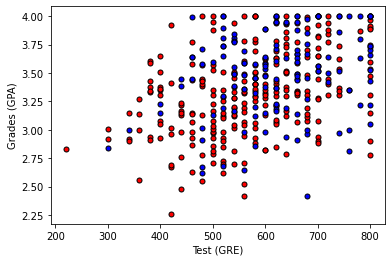

In [4]:
# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([r[0][0] for r in rejected], [r[0][1] for r in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([a[0][0] for a in admitted], [a[0][1] for a in admitted], s = 25, color = 'blue', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable. Let's make 4 plots, each one for each rank.

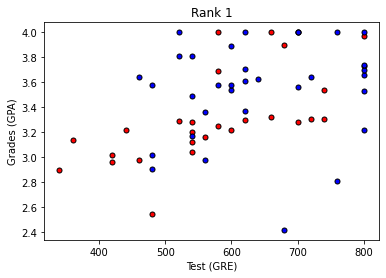

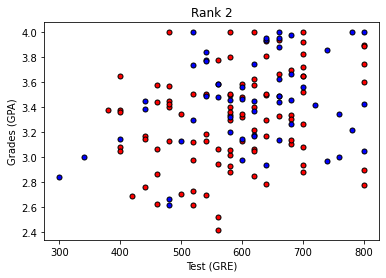

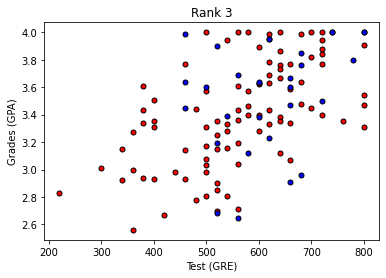

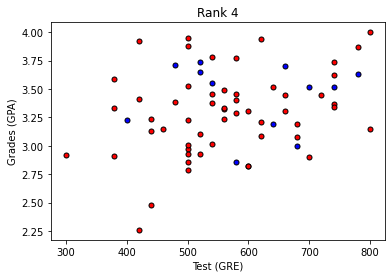

In [5]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should use one-hot encodeing.

# One-hot encoding the rank


In [6]:
#Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

#Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 5 rows of our data
one_hot_data.head(5)

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


# Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to learn. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [7]:
# Making a copy of our data
processed_data = one_hot_data[:]

#Scale the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4.0
# Printing the first 10 rows of our procesed data
processed_data.head(5)

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1


In [8]:
# In order to test our algorithm, we'll split the data into a Training and a Testing set. 
# The size of the testing set will be 10% of the total data.
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)
print("Number of training samples: ", len(train_data))
print("Number of testing samples: ", len(test_data))

Number of training samples:  360
Number of testing samples:  40


# Now we have processed data which can be used to create NN. I will implement 3 models for comparision:

- Model 1. Hand written 2- layer ANN
- Model 2. ANN using Keras
- Model 3. ANN using PyTorch

#  Model 1. Hand written 2-layer Neural Network

In [10]:
# Now, we'll split the data into features (X) and targets (y).
features = train_data.drop('admit', axis=1)
targets = train_data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']


The following function trains the 2-layer neural network. 

In [11]:
# Lets create the fucntions needed in Neural Network

# 1. sigmoid function 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 2. sigmoid function derivative
def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))

# 3. error function to estimate loss
def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

# 4. Error term for backpropagation (derivative)
def error_term_formula(y, output):
    return (y-output) * output * (1 - output)


In [12]:
# Neural Network hyperparameters
epochs = 2000
learnrate = 0.05

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            output = sigmoid(np.dot(x, weights))

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            #   Notice we calulate f'(h) here instead of defining a separate
            #   sigmoid_prime function. 
            error_term = error_term_formula(y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * x

        # Update the weights here. 
        weights += learnrate * del_w / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 5) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(features, targets, epochs, learnrate)

Epoch: 0
Train loss:  0.27906727446613144
Epoch: 400
Train loss:  0.21110269756748734
Epoch: 800
Train loss:  0.20727474946131513
Epoch: 1200
Train loss:  0.2058361918132592
Epoch: 1600
Train loss:  0.20486788120749755
Finished training!


In [15]:
# Calculate accuracy on test data
tes_out = sigmoid(np.dot(features_test, weights))
predictions = tes_out > 0.5
accuracy = np.mean(predictions == targets_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.575


# Model 2. ANN using Keras

In [16]:
#importing keras and useful libraries
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
features = np.array(train_data.drop('admit', axis=1))
targets = np.array(keras.utils.to_categorical(train_data['admit'], 2))
features_test = np.array(test_data.drop('admit', axis=1))
targets_test = np.array(keras.utils.to_categorical(test_data['admit'], 2))

print(features[:2])
print(targets[:2])

Using TensorFlow backend.


[[0.95   0.7025 1.     0.     0.     0.    ]
 [0.8    0.94   0.     0.     1.     0.    ]]
[[0. 1.]
 [1. 0.]]


In [17]:
# Building the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=features[0].shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 9,282
Trainable params: 9,282
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Training the model
model.fit(features, targets, epochs=200, batch_size=10, verbose=0)

In [20]:
# Evaluating the model on the training and testing set
score = model.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

360/360 [==============================] - 0s 61us/step

 Training Accuracy: 0.7472222447395325
40/40 [==============================] - 0s 50us/step

 Testing Accuracy: 0.6499999761581421


# Model 3. ANN using PyTorch

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import keras

Using TensorFlow backend.


In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features = np.array(train_data.drop('admit', axis=1))
targets = np.array(keras.utils.to_categorical(train_data['admit'], 2))
features_test = np.array(test_data.drop('admit', axis=1))
targets_test = np.array(keras.utils.to_categorical(test_data['admit'], 2))

# converting numpy array to torch tensors
X_train = torch.from_numpy(features.astype(np.float32))
y_train = torch.from_numpy(targets[:,0].astype(np.float32))
X_test = torch.from_numpy(features_test.astype(np.float32))
y_test = torch.from_numpy(targets_test[:,0].astype(np.float32))

y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

torch.Size([360, 6])
torch.Size([360, 1])
torch.Size([40, 1])
torch.Size([40, 6])


In [16]:
# Fully connected neural network with 3 hidden layers
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()      
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, num_classes) 
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.sigmoid(out)
        return out

# Hyper-parameters 
input_size = 6 
hidden_size = 400 
num_classes = 1
num_epochs = 40
learning_rate = 0.01    
    
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
print(model)

NeuralNet(
  (l1): Linear(in_features=6, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=400, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [21]:
for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    #print(y_pred)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()
    # print(loss)
    
    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 50 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

#testing the model
with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'Test accuracy: {acc.item():.4f}')

Test accuracy: 0.6500
